# Lab 7 Tutorial: Deep Learning for text

In [1]:
# Global imports and settings
from preamble import *
from tensorflow import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 300 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using Keras 2.2.4-tf


## 3 examples
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

We'll use the Keras API, integrated in TensorFlow 2.  
Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)
* Hence, this data is already preprocessed. If you want to start from raw text data, you need to [Tokenize](https://keras.io/preprocessing/text/#tokenizer) the text first.

In [2]:
from tensorflow.keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


The data is encoded as sequences of word IDs, so we need to properly encode them first.
We could use a word embedding (see later), or [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), but for now we will just one-hot-encode them. For instance, if the text contains word '14', the 14th feature should be '1'. The following is a helper function for doing this. We also need to convert the target label to floats, since they need to be compared with the numerical outputs of the neural net.

In [3]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("Encoded review: ", train_data[0][0:10])
print("One-hot-encoded review: ", x_train[0][0:10])

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("Label for the first review: ", y_train[0])

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
One-hot-encoded review:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
Label for the first review:  1.0


#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* For now, we start with 2 layers of 16 hidden units each
* Output layer: since this is a binary classification problem, we will use a single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* The loss function should be binary cross-entropy.

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Note: for more control, you can explictly create the optimizer, loss, and metrics. 
You can also change hyperparameters such as the SGD learning rate.

``` python
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
```

#### Model selection
* To tune the hyperparameters, split the training data into a training and validation set.
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
    - The `History` object contains the loss, accuracy, validation loss, and validation accuracy for every epoch.
* We start with 20 epochs in minibatches of 512 samples

In [5]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=1,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 7s 481us/sample - loss: 0.5434 - accuracy: 0.7625 - val_loss: 0.4202 - val_accuracy: 0.8604
Epoch 2/20
15000/15000 [==============================] - 2s 146us/sample - loss: 0.3341 - accuracy: 0.8971 - val_loss: 0.3295 - val_accuracy: 0.8774
Epoch 3/20
15000/15000 [==============================] - 3s 195us/sample - loss: 0.2390 - accuracy: 0.9279 - val_loss: 0.2854 - val_accuracy: 0.8894
Epoch 4/20
15000/15000 [==============================] - 2s 115us/sample - loss: 0.1860 - accuracy: 0.9448 - val_loss: 0.2759 - val_accuracy: 0.8885
Epoch 5/20
15000/15000 [==============================] - 2s 119us/sample - loss: 0.1530 - accuracy: 0.9541 - val_loss: 0.2784 - val_accuracy: 0.8881
Epoch 6/20
15000/15000 [==============================] - 2s 109us/sample - loss: 0.1227 - accuracy: 0.9644 - val_loss: 0.3040 - val_accuracy: 0.8812
Epoch 7/20
15000/15000 [==========================

We can now visualize the learning curves
* The training loss keeps decreasing, due to gradient descent
* The validation loss peaks after a few epochs, after which the model starts to overfit

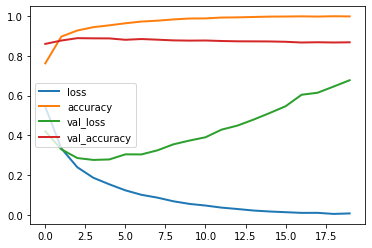

In [6]:
# Using pandas' built-in plotting of series
pd.DataFrame(history.history).plot(lw=2);

#### Predictions
Out of curiosity, let's look at a few predictions:

In [7]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.004]

Review 16:  ? from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem ? he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone could make the movie like this i don't believe so thanks

### Using Keras models with the scikit-learn API
* Model selection can be tedious with the Keras API
* We can wrap a Keras model as a scikit-learn estimator and use the scikit-learn API instead
* For instance, we can now use a grid search to tune the number of epochs and the size of the hidden laayers.
* Note that we need a helper function `make_model` to pass some of the hyperparameters to the Keras model 

In [8]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = models.Sequential()
    model.add(layers.Dense(hidden_size, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(hidden_size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)
param_grid = {'epochs': [1, 5, 10],  # epochs is fit parameter, not in make_model!
              'hidden_size': [8, 16, 32],
              'verbose' : [0]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=3, return_train_score=True)
grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x13cc842b0>,
             iid='deprecated', n_jobs=None,
             param_grid={'epochs': [1, 5, 10], 'hidden_size': [8, 16, 32],
                         'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Grid search results

In [9]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_epochs param_hidden_size                                   
1            8                             0.89              0.93
             16                            0.88              0.93
             32                            0.89              0.94
5            8                             0.88              0.97
             16                            0.88              0.97
             32                            0.88              0.98
10           8                             0.87              0.98
             16                            0.87              0.99
             32                            0.87              1.00

### Multi-class classification (topic classification)
* Dataset: 11,000 news stories, 46 topics
    - Included in Keras, with a 50/50 train-test split
* Each row is one news story, with only the 10,000 most frequent words retained
* Again, each word is replaced by a _word index_ (word ID)

In [10]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

News wire:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Encoded:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7]
Topic:  3


#### Preparing the data
* As in the previous example, we need to vectorize the data (e.g. using one-hot-encoding)
* Since we now have 46 classes, we need to vectorize the labels as well
    - We can use one-hot-encoding with Keras' `to_categorical` utility
    - This yields a vector of 46 floats (0/1) for every sample

In [11]:
from tensorflow.keras.utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### Building the model
* This time we use 64 hidden units because we have many more classes to learn. 
* In the final layer we can still use the softmax activation function.
* The loss function is now `categorical_crossentropy`

In [12]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training and tuning
* We again take a validation set from the training set
* We fit the model with 20 epochs
* Plot the learning curves

In [13]:
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

In [14]:
history2 = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, verbose=1,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 305us/sample - loss: 2.6350 - accuracy: 0.5214 - val_loss: 1.7469 - val_accuracy: 0.6380
Epoch 2/20
7982/7982 [==============================] - 1s 139us/sample - loss: 1.4123 - accuracy: 0.7036 - val_loss: 1.3280 - val_accuracy: 0.7150
Epoch 3/20
7982/7982 [==============================] - 1s 88us/sample - loss: 1.0558 - accuracy: 0.7761 - val_loss: 1.1527 - val_accuracy: 0.7480
Epoch 4/20
7982/7982 [==============================] - 1s 80us/sample - loss: 0.8308 - accuracy: 0.8218 - val_loss: 1.0561 - val_accuracy: 0.7750
Epoch 5/20
7982/7982 [==============================] - 1s 80us/sample - loss: 0.6630 - accuracy: 0.8629 - val_loss: 0.9835 - val_accuracy: 0.8010
Epoch 6/20
7982/7982 [==============================] - 1s 75us/sample - loss: 0.5346 - accuracy: 0.8890 - val_loss: 0.9564 - val_accuracy: 0.8020
Epoch 7/20
7982/7982 [==============================] - 1s 77us/samp

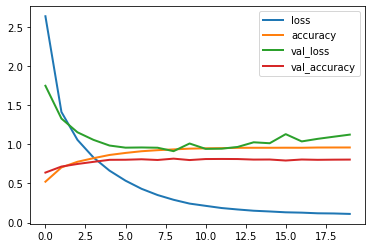

In [15]:
pd.DataFrame(history2.history).plot(lw=2);

In [16]:
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0)
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

2246/2246 [==============================] - 0s 78us/sample - loss: 1.3884 - accuracy: 0.7720
Loss: 1.3884, Accuracy: 0.7720


### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [17]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)

In [18]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Preprocessing
* Neural nets work a lot better if we standardize the features first. 
* Keras has no built-in support so we have to do this ourselves
    - We can use scikit-learn preprocessors and build a pipeline with KerasClassifier

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = []
estimators.append(('standardise', StandardScaler()))
estimators.append(('keras', KerasRegressor(build_fn=build_model)))
pipeline = Pipeline(estimators)

* Evaluate the Keras pipeline with cross-validation

In [20]:
from sklearn.model_selection import cross_validate
clf = KerasClassifier(build_model)
X = np.concatenate([train_data,test_data],axis=0)
y = np.concatenate([train_targets,test_targets],axis=0)
scores = cross_validate(pipeline, X, y, cv=3,
                        scoring=('neg_mean_squared_error'),
                        return_train_score=True,
                        fit_params={'keras__epochs': 50, 'keras__batch_size':1, 'keras__verbose':0})

In [21]:
print("MAE: ", -np.mean(scores['test_score']))

MAE:  12.268424946605272


## Regularization

Adding L1/L2 regularization
* The input (0.001) is the alpha value

In [33]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
l2_model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 16)                160016    
_________________________________________________________________
dense_116 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Adding dropout
* The input (0.5) is the dropout rate

In [34]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))
dpt_model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 16)                160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


### Word embeddings in Keras
* Uses a pre-trained embedding, obtained using GloVe
* See a complete example [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)


In [35]:
from tensorflow.keras.layers import Embedding, Flatten, Dense

max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 300 # vocabulary size
# define the model
model = models.Sequential()
model.add(Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 6001      
Total params: 3,006,001
Trainable params: 3,006,001
Non-trainable params: 0
_________________________________________________________________
None


### Further reading

https://www.tensorflow.org/learn

http://playground.tensorflow.org

https://www.tensorflow.org/tensorboard